In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

C:\Users\Acer\AppData\Local\Temp\ipykernel_15048\1573469370.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [7]:
def preprocess_dataset(dataset_path):
    df = pd.read_csv(dataset_path, usecols=['Step Time', 'Voltage', 'Current', 'Temperature', 'Capacity'], skiprows=range(1, 28), low_memory=False)

    df['Step Time'] = pd.to_datetime(df['Step Time'], format='%H:%M:%S.%f')
    df = df.set_index('Step Time')

    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

    # Resample data ke interval 1S
    df_resampled = df[numeric_columns].resample('1S').mean()
    
    # Reset index and keep 'Step Time' as continuous range
    df_resampled = df_resampled.reset_index()
    df_resampled['Step Time'] = range(1, len(df_resampled) + 1)

    scaler = MinMaxScaler()
    columns_to_normalize = ['Voltage', 'Current', 'Temperature', 'Capacity']
    df_normalized = df_resampled.copy()  
    df_normalized[columns_to_normalize] = scaler.fit_transform(df_resampled[columns_to_normalize])

    df_normalized['SOC'] = (df_normalized['Capacity'] / df_normalized['Capacity'].max()) * 100

    # Cleaning data masing-masing training
    if '763_HWFET' in dataset_path:
        df_normalized = df_normalized.iloc[601:]
    elif '780_Mixed1' in dataset_path:
        df_normalized = df_normalized.iloc[2091:]
    elif '783_Mixed3' in dataset_path:
        df_normalized = df_normalized.iloc[628:]
    elif '783_Mixed4' in dataset_path:
        df_normalized = df_normalized.iloc[1714:]
    elif '783_Mixed5' in dataset_path:
        df_normalized = df_normalized.iloc[1023:]
    elif '783_Mixed6' in dataset_path:
        df_normalized = df_normalized.iloc[797:]
    elif '783_Mixed7' in dataset_path:
        df_normalized = df_normalized.iloc[611:]
    elif '783_Mixed8' in dataset_path:
        df_normalized = df_normalized.iloc[2375:]
    
    # Reset index and Step Time column
    df_normalized = df_normalized.reset_index(drop=True)
    df_normalized['Step Time'] = range(1, len(df_normalized) + 1)

    return df_normalized


In [8]:
# Preprocess dataset testing
testing_dataset_path = 'C:/Users/Acer/Documents/Bismillah Skripsi/Datanya/Turnigy Graphene 5000mAh 65C Li-ion Battery Data/40 degC/763_HWFET.csv'
df_testing = preprocess_dataset(testing_dataset_path)

C:\Users\Acer\AppData\Local\Temp\ipykernel_11868\3736749337.py:10: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_resampled = df[numeric_columns].resample('1S').mean()


In [9]:
# Save normalized DataFrame testing to CSV
output_path_testing = 'C:/Users/Acer/Documents/Bismillah Skripsi/Kodingan Untuk Skripsi/Turnigy lithium polimer/Training dan Testing/Testing_HWFET_40 Deg.csv'
df_testing.to_csv(output_path_testing, index=False)
print(f"Normalized testing DataFrame berhasil save di '{output_path_testing}'")

Normalized testing DataFrame berhasil save di 'C:/Users/Acer/Documents/Bismillah Skripsi/Kodingan Untuk Skripsi/Turnigy lithium polimer/Training dan Testing/Testing_HWFET_40 Deg.csv'


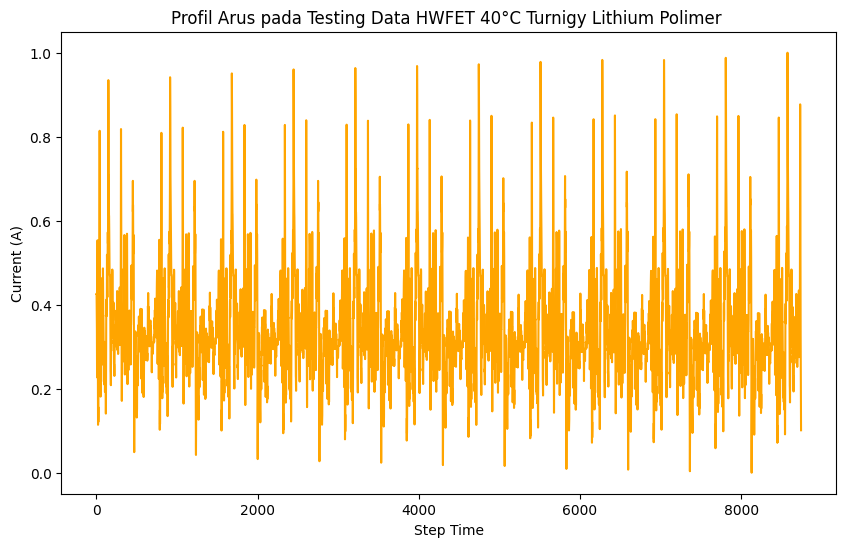

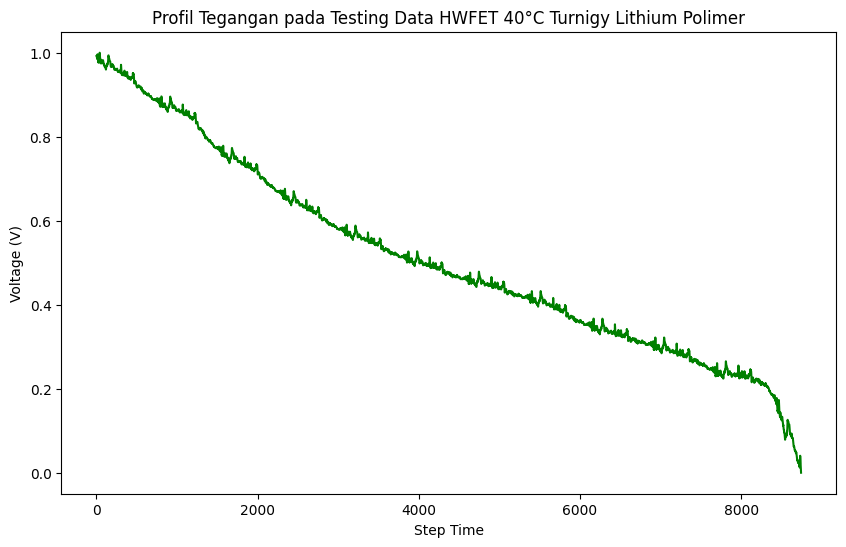

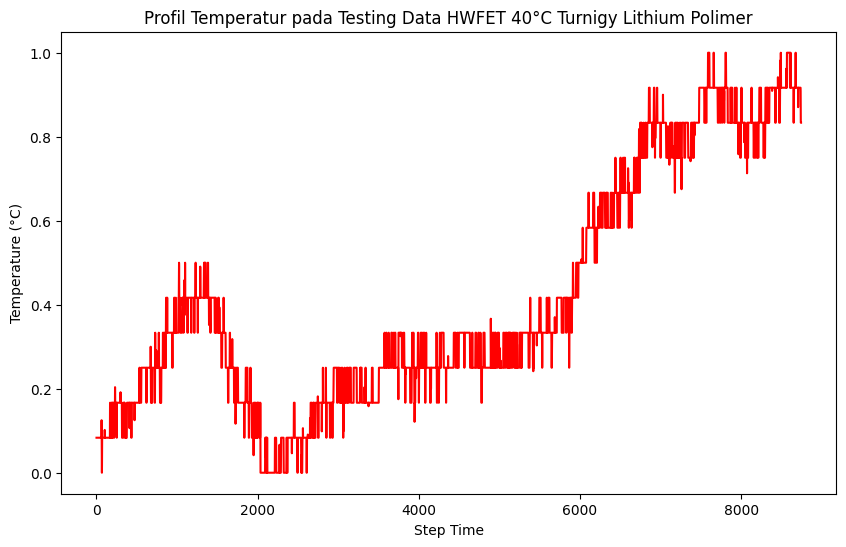

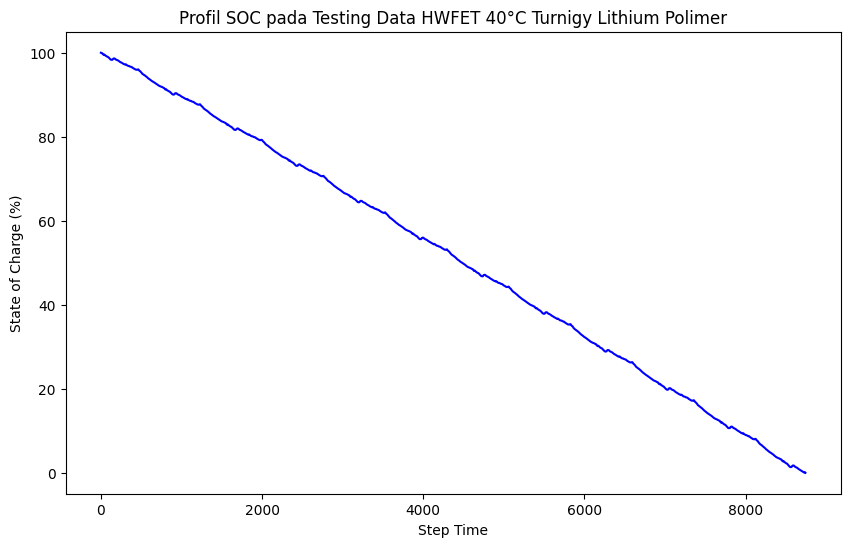

In [10]:
# Plot Current untuk testing
plt.figure(figsize=(10, 6))
plt.plot(df_testing['Step Time'], df_testing['Current'], color='orange')
plt.title('Profil Arus pada Testing Data HWFET 40°C Turnigy Lithium Polimer ')
plt.xlabel('Step Time')
plt.ylabel('Current (A)')
plt.show()

# Plot Voltage untuk testing
plt.figure(figsize=(10, 6))
plt.plot(df_testing['Step Time'], df_testing['Voltage'], color='green')
plt.title('Profil Tegangan pada Testing Data HWFET 40°C Turnigy Lithium Polimer')
plt.xlabel('Step Time')
plt.ylabel('Voltage (V)')
plt.show()

# Plot Temperature untuk testing
plt.figure(figsize=(10, 6))
plt.plot(df_testing['Step Time'], df_testing['Temperature'], color='red')
plt.title('Profil Temperatur pada Testing Data HWFET 40°C Turnigy Lithium Polimer')
plt.xlabel('Step Time')
plt.ylabel('Temperature (°C)')
plt.show()

# Plot SOC untuk testing
plt.figure(figsize=(10, 6))
plt.plot(df_testing['Step Time'], df_testing['SOC'], color='blue')
plt.title('Profil SOC pada Testing Data HWFET 40°C Turnigy Lithium Polimer')
plt.xlabel('Step Time')
plt.ylabel('State of Charge (%)')
plt.show()

In [3]:
# Load testing data
testing_data_path = 'C:/Users/Acer/Documents/Bismillah Skripsi/Kodingan Untuk Skripsi/Turnigy lithium polimer/Training dan Testing/Testing_HWFET_40 Deg.csv'
testing_data = pd.read_csv(testing_data_path)

# Split features and target variable
X_test = testing_data[['Voltage', 'Current', 'Temperature']]
y_test = testing_data['SOC']

# Reshape input data to fit LSTM model requirements [samples, timesteps, features]
X_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

In [4]:
model_jalur= 'C:/Users/Acer/Documents/Bismillah Skripsi/Kodingan Untuk Skripsi/Turnigy lithium polimer/hasil model/lstm_40 C_model2.h5'
history_jalur = 'C:/Users/Acer/Documents/Bismillah Skripsi/Kodingan Untuk Skripsi/Turnigy lithium polimer/hasil model/training_history2_lstm_40 C.csv'

# Metode untuk memuat model dan riwayat pelatihan
def load_model_and_history(model_jalur, history_jalur):
    # Memuat model
    loaded_model = tf.keras.models.load_model(model_jalur)
    
    # Memuat riwayat pelatihan
    loaded_history = pd.read_csv(history_jalur)
    
    return loaded_model, loaded_history

# Memuat kembali model dan riwayat pelatihan
loaded_model, loaded_history = load_model_and_history(model_jalur, history_jalur)

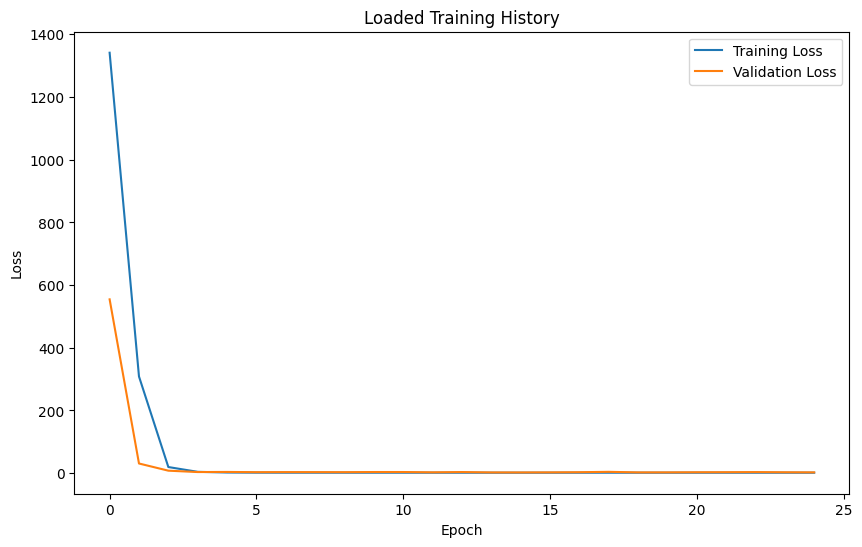

In [5]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(loaded_history['loss'], label='Training Loss')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.title('Loaded Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
# ngecek data testing
print("Preview testing data:")
print(testing_data.head())
print('\n')

Preview testing data:
   Step Time   Voltage   Current  Temperature  Capacity        SOC
0          1  0.825752  0.361645     0.173304  0.871693  87.169298
1          2  0.824642  0.344008     0.173304  0.871595  87.159475
2          3  0.824360  0.344562     0.173304  0.871490  87.149043
3          4  0.823600  0.328753     0.173304  0.871383  87.138252
4          5  0.822683  0.317975     0.173304  0.871259  87.125913




274/274 [==============================] - 3s 4ms/step - loss: 1.5950
Testing Loss: 1.59499990940094
274/274 [==============================] - 2s 4ms/step


c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.9624403148058569
Root Mean Squared Error (RMSE): 1.2629331740446246


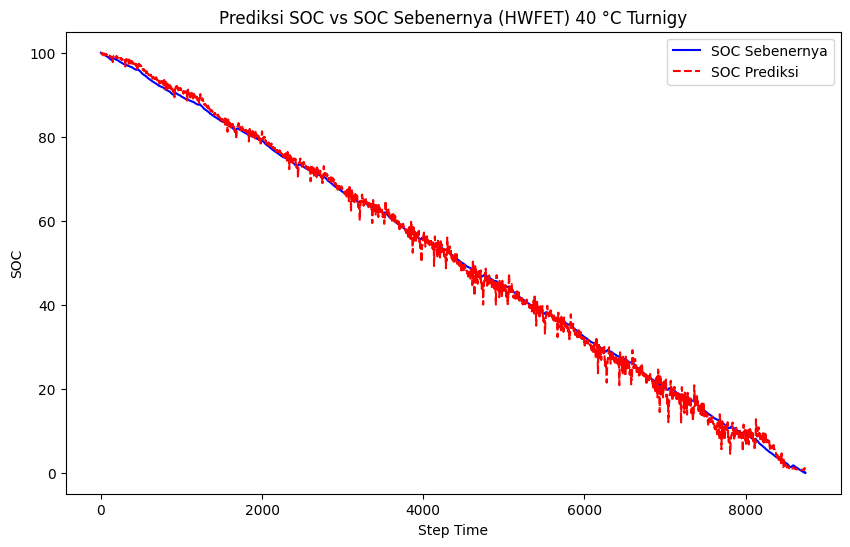

In [8]:
# Load model
model_jalur= 'C:/Users/Acer/Documents/Bismillah Skripsi/Kodingan Untuk Skripsi/Turnigy lithium polimer/hasil model/lstm_40 C_model2.h5'
model = load_model(model_jalur)

# Evaluasi model dengan testing data
loss = model.evaluate(X_test, y_test)
print(f'Testing Loss: {loss}')

# Prediksi SOC dengan model
y_pred = model.predict(X_test)

# Hitung MAE dan RMSE untuk data testing dengan model
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Plot asli vs prediksi SOC
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='SOC Sebenernya', color='blue', linestyle='-')
plt.plot(y_pred, label='SOC Prediksi', color='red', linestyle='--')
plt.title('Prediksi SOC vs SOC Sebenernya (HWFET) 40 °C Turnigy')
plt.xlabel('Step Time')
plt.ylabel('SOC')
plt.legend()
plt.show()